# Lending Club - Probabilistic Programming Project
## *Data Exploration and simple inference*

In [1]:
from os import getcwd
import glob
from pprint import pprint

import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

*These files contain complete loan data for all loans issued through the time period stated, including the current loan status (Current, Late, Fully Paid, etc.) and latest payment information. The file containing loan data through the "present" contains complete loan data for all loans issued through the previous completed calendar quarter.*

In [2]:
csv_files = glob.glob(f'{getcwd()}/data/*.csv')
df = pd.concat((pd.read_csv(f, header=1, low_memory=False) for f in csv_files))

In [3]:
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,1077501,NaN,5000.0,5000.0,4975.0,36 months,10.65%,162.87,B,B2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,NaN,2500.0,2500.0,2500.0,60 months,15.27%,59.83,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,NaN,2400.0,2400.0,2400.0,36 months,15.96%,84.33,C,C5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,NaN,10000.0,10000.0,10000.0,36 months,13.49%,339.31,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,NaN,3000.0,3000.0,3000.0,60 months,12.69%,67.79,B,B5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
dic = pd.read_excel('data/LCDataDictionary.xlsx')

In [5]:
dic.head()

,LoanStatNew,Description
0,acc_now_delinq,The number of accounts on which the borrower i...
1,acc_open_past_24mths,Number of trades opened in past 24 months.
2,addr_state,The state provided by the borrower in the loan...
3,all_util,Balance to credit limit on all trades
4,annual_inc,The self-reported annual income provided by th...


Seems like expected default rate is missing (it's in the dict but not in the data), too bad...

Note that ids appear only once i.e. we have only one data point per loan. Also, member_id is missing in this version of the dataset (but on other versions it was there but still 1 data point per member_id)

In [6]:
df = df[['annual_inc', 'avg_cur_bal', 'loan_status','int_rate', 'emp_length',
           'funded_amnt', 'grade', 'home_ownership', 'loan_amnt']]

In [7]:
df.head()

,annual_inc,avg_cur_bal,loan_status,int_rate,emp_length,funded_amnt,grade,home_ownership,loan_amnt
0,24000.0,NaN,Fully Paid,10.65%,10+ years,5000.0,B,RENT,5000.0
1,30000.0,NaN,Charged Off,15.27%,< 1 year,2500.0,C,RENT,2500.0
2,12252.0,NaN,Fully Paid,15.96%,10+ years,2400.0,C,RENT,2400.0
3,49200.0,NaN,Fully Paid,13.49%,10+ years,10000.0,C,RENT,10000.0
4,80000.0,NaN,Fully Paid,12.69%,1 year,3000.0,B,RENT,3000.0


In [8]:
df.describe()

,annual_inc,avg_cur_bal,funded_amnt,loan_amnt
count,2.004058e+06,1.933741e+06,2.004062e+06,2.004062e+06
mean,7.754658e+04,1.351936e+04,1.491479e+04,1.492073e+04
std,1.148550e+05,1.636573e+04,9.054065e+03,9.056246e+03
min,0.000000e+00,0.000000e+00,5.000000e+02,5.000000e+02
25%,4.600000e+04,3.099000e+03,8.000000e+03,8.000000e+03
50%,6.500000e+04,7.374000e+03,1.280000e+04,1.280000e+04
75%,9.200000e+04,1.874400e+04,2.000000e+04,2.000000e+04
max,1.100000e+08,9.580840e+05,4.000000e+04,4.000000e+04


In [9]:
df.isnull().mean()

annual_inc        0.000016
avg_cur_bal       0.035103
loan_status       0.000014
int_rate          0.000014
emp_length        0.062295
funded_amnt       0.000014
grade             0.000014
home_ownership    0.000014
loan_amnt         0.000014
dtype: float64

Not too many missing values, we'll just drop them for now.

In [8]:
for c in df.columns:
    df = df[~df[c].isnull()]

In [9]:
df.shape

(1810995, 9)

## 1. Data exploration (univariate)

## Characteristics of the borrower

### Income (num)

/Users/jeromekafrouni/.pyenv/versions/3.6.1/envs/prob-prog/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


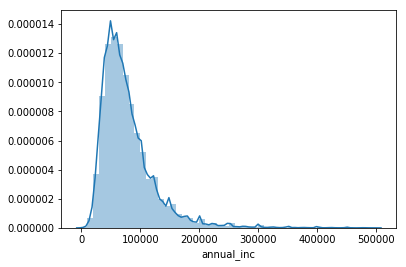

In [12]:
sns.distplot(df.loc[df['annual_inc'] < 5*1e5, 'annual_inc']);

### Employment length (num, but needs preprocess)

### Home Ownership (cat)

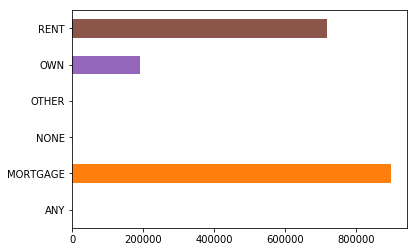

In [19]:
df['home_ownership'].value_counts().sort_index().plot(kind='barh');

**TODO** visualize mortgage and default vs others

-----

## Characteristics of the loan

### Balance of the loan (num)

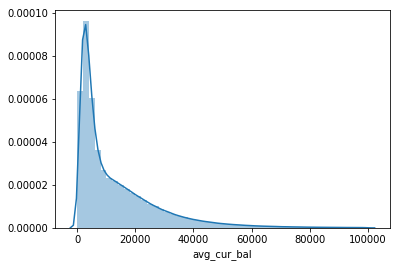

In [20]:
sns.distplot(df.loc[df['avg_cur_bal'] < 1e5, 'avg_cur_bal']);

### Loan amount (num)

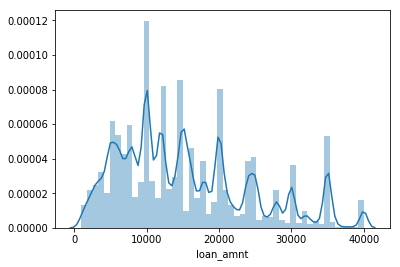

In [21]:
sns.distplot(df['loan_amnt']);

There are some peaks because people tend to borrow round amounts. Hopefully this won't affect our analysis too much (these are not real moments of the distribution...)

### Status (cat)

In [22]:
df['loan_status'].value_counts()

Fully Paid            825222
Current               742296
Charged Off           206098
Late (31-120 days)     20989
In Grace Period        11262
Late (16-30 days)       5107
Default                   21
Name: loan_status, dtype: int64

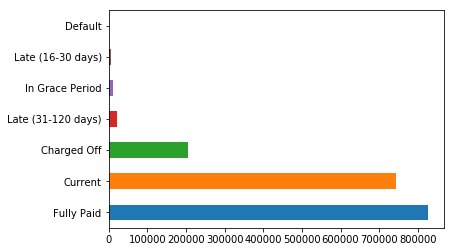

In [23]:
df['loan_status'].value_counts().plot(kind='barh');

- Charged off = the creditor knows its borrower won't pay back (usually if the borrower hasn't been paying for a while)
- In grace period = borrower has a short amount of time (15 days?) to pay, if he does so it's considered on time

There are very (very) few defaults, but we might be able to learn well the charged off ones

### Interest rate (num)

**Note** this didn't fail on previous versions of the dataset but seems to crash now... TODO fixme

In [ ]:
sns.distplot(df['int_rate']);

### Funded amount (num)

In [ ]:
sns.distplot(df['funded_amnt']);

### Grade (cat, ordered)

In [ ]:
df['grade'].value_counts().sort_index().plot(kind='barh');

**TODO** visualize grade and loan amount together, same with income, etc

## 2. Visualize interactions between vars

### Simple interactions

TODO

### Correlation matrix (heatmap)

TODO

## 3. Basic inference

In [25]:
import tensorflow as tf
import edward as ed

To debug, work on small dataset:

In [104]:
np.random.seed = 0
random_index = np.random.choice(df.shape[0], size=10000, replace=False)
df_small = df.iloc[random_index]

### 3.1 Modelling revenue alone:

**TODO**

### 3.2 Modeling annual inc vs loan amnt (linear regression)

It seems like people with higher income would tend to borrow more money. Let's try to model this relationship. This is a very simple analysis but it's good to test that everything is working fine with Edward and our dataset etc.

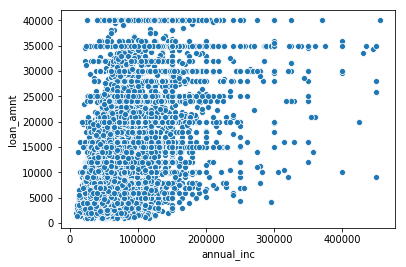

In [15]:
sns.scatterplot(df_small.loc[df_small['annual_inc'] < 5*1e5, 'annual_inc'],
                df_small.loc[df_small['annual_inc'] < 5*1e5, 'loan_amnt']);

#### 3.2.1 Model

In [105]:
N = 9000 # number of data points (training)
D = 1 # number of features (only annual_inc)

In [106]:
X_train, y_train = df_small.iloc[:N]['annual_inc'], df_small.iloc[:N]['loan_amnt']
X_test, y_test = df_small.iloc[N:]['annual_inc'], df_small.iloc[N:]['loan_amnt']

X_train, y_train = np.array(X_train), np.array(y_train)
X_test, y_test = np.array(X_test), np.array(y_test)

X_train, X_test = X_train.reshape(-1, 1), X_test.reshape(-1, 1)

From linear regression tutorial:

In [107]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

In [108]:
X = tf.placeholder(tf.float32, [None, D]) # None instead of N should work for both train and test
w = ed.models.Normal(loc=tf.zeros(D), scale=tf.ones(D))
b = ed.models.Normal(loc=tf.zeros(1), scale=tf.ones(1))
y = ed.models.Normal(loc=ed.dot(X, w) + b, scale=tf.ones(1))

In [109]:
qw = ed.models.Normal(loc=tf.get_variable("qw/loc", [D]),
            scale=tf.nn.softplus(tf.get_variable("qw/scale", [D])))
qb = ed.models.Normal(loc=tf.get_variable("qb/loc", [1]),
            scale=tf.nn.softplus(tf.get_variable("qb/scale", [1])))

#### 3.2.2 Inference

In [110]:
inference = ed.KLqp({w: qw, b: qb}, data={X: X_train, y: y_train})
inference.run(n_samples=5, n_iter=250)

250/250 [100%] ██████████████████████████████ Elapsed: 2s | Loss: 479443648512.000


**Note**: inference on the full dataset for this simple model takes 30 sec (and very bad results).

#### 3.2.3 Criticism

Evaluate on held-out y_test:

In [111]:
y_post = ed.copy(y, {w: qw, b: qb})

In [112]:
print("Mean squared error on test data:")
print(ed.evaluate('mean_squared_error', data={X: X_test, y_post: y_test}))

print("Mean absolute error on test data:")
print(ed.evaluate('mean_absolute_error', data={X: X_test, y_post: y_test}))

Mean squared error on test data:
130992720.0
Mean absolute error on test data:
7340.2637
